In [79]:
%%configure -f
{"executorMemory": "2G","driverMemory":"1G","executorCores": 1,"numExecutors": 3, 
 "conf": {"spark.dynamicAllocation.enabled": "false", 
          "spark.sql.parquet.enableVectorizedReader": "false", 
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type": "native",
          "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"}}



Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
151,application_1681238404028_0206,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
151,application_1681238404028_0206,pyspark,idle,Link,Link,None,✔


In [80]:
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("s3://msbx5420-spr23/team1/Fraud_Detection.csv") \
    .dropDuplicates()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
df.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step| type|amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  22|DEBIT|216.19|C1444210311|          0.0|           0.0|C1981278780|     498988.87|     499205.05|      0|             0|
+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
only showing top 1 row

In [82]:
df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6362620

In [83]:
#creating a destination column for customer and merchant 
from pyspark.sql.functions import when, col

df = df.withColumn("Type_Dest", when(col("nameDest").startswith("C"), "Customer_Dest").when(col("nameDest").startswith("M"), "Merchant_Dest").otherwise("Other"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
#creating an original column for customer/merchant 
from pyspark.sql.functions import when, col
df = df.withColumn("Type_Orig", when(col("nameOrig").startswith("C"), "Customer_Orig").when(col("nameOrig").startswith("M"), "Merchant_Orig").otherwise("Other"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
df.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------+-------------+
|step| type|amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|    Type_Dest|    Type_Orig|
+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------+-------------+
|  22|DEBIT|216.19|C1444210311|          0.0|           0.0|C1981278780|     498988.87|     499205.05|      0|             0|Customer_Dest|Customer_Orig|
+----+-----+------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------+-------------+
only showing top 1 row

In [86]:
from pyspark.sql.functions import corr
corr_value = df.select(corr('isFraud', 'isFlaggedFraud')).collect()[0][0]
print(corr_value)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.04410919651380884

In [87]:
from pyspark.sql.functions import sum as pyspark_sum

fraud_sum = df.select(pyspark_sum('isFraud')).collect()[0][0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
print(fraud_sum)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8213

In [89]:
flagged_sum = df.select(pyspark_sum('isFlaggedFraud')).collect()[0][0]
print(flagged_sum)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16

#Creating new hour/day/time of day columns

In [90]:
# looking at the max step 
from pyspark.sql.functions import max

max_step = df.agg(max("step")).collect()[0][0]
print("The maximum value in the 'step' column is:", max_step)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The maximum value in the 'step' column is: 743

In [91]:
# looking at the min step
from pyspark.sql.functions import min

min_step = df.agg(min("step")).collect()[0][0]
print("The minimum value in the 'step' column is:", min_step)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The minimum value in the 'step' column is: 1

In [92]:
# null/missing values
from pyspark.sql.functions import count, when, col

null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts_dict = null_counts.first().asDict()

for col_name, null_count in null_counts_dict.items():
    print(f"Column '{col_name}' has {null_count} null values.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Column 'step' has 0 null values.
Column 'type' has 0 null values.
Column 'amount' has 0 null values.
Column 'nameOrig' has 0 null values.
Column 'oldbalanceOrg' has 0 null values.
Column 'newbalanceOrig' has 0 null values.
Column 'nameDest' has 0 null values.
Column 'oldbalanceDest' has 0 null values.
Column 'newbalanceDest' has 0 null values.
Column 'isFraud' has 0 null values.
Column 'isFlaggedFraud' has 0 null values.
Column 'Type_Dest' has 0 null values.
Column 'Type_Orig' has 0 null values.

In [93]:
# code to calculate time of day and create a new hour of day column
from pyspark.sql.functions import when

df = df.withColumn("hour_of_day", (df.step - 1) % 24)  # Calculate the hour of the day

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [94]:
from pyspark.sql.functions import floor

df = df.withColumn("day", floor((df.step - 1) / 24) + 1)  # Calculate the day number

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
df = df.withColumn("time_of_day", 
                   when((df.hour_of_day >= 5) & (df.hour_of_day < 12), "morning")
                   .when((df.hour_of_day >= 12) & (df.hour_of_day < 17), "afternoon")
                   .when((df.hour_of_day >= 17) & (df.hour_of_day < 21), "evening")
                   .otherwise("night"))  # Assign labels based on hour of the day

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
#checking to make sure that the previous transformations worked
df.filter(df.day == 2).show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------+-------------+-----------+---+-----------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|    Type_Dest|    Type_Orig|hour_of_day|day|time_of_day|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------+-------------+-----------+---+-----------+
|  25|CASH_OUT|199003.99|C1247481470|          0.0|           0.0| C976896991|    2665734.96|    2864738.95|      0|             0|Customer_Dest|Customer_Orig|          0|  2|      night|
|  25|TRANSFER| 751516.7| C365227395|      16594.0|           0.0| C453497137|     186316.71|      937833.4|      0|             0|Customer_Dest|Customer_Orig|          0|  2|      night|
|  25|CASH_OUT|130824.67| C476662334|      25298.0|         

#Querying to look at distributions of fraud

In [97]:
df.createOrReplaceTempView("my_table")

fraud_by_ToD = spark.sql("""
    SELECT (time_of_day) as ToD, sum(isFraud) as fraud_count
    FROM my_table
    GROUP BY time_of_day order by fraud_count
""")

fraud_by_ToD.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+
|      ToD|fraud_count|
+---------+-----------+
|  evening|       1372|
|afternoon|       1738|
|  morning|       2433|
|    night|       2670|
+---------+-----------+

In [98]:
%%spark -o pandas_df
pandas_df = fraud_by_ToD
pandas_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+
|      ToD|fraud_count|
+---------+-----------+
|  evening|       1372|
|afternoon|       1738|
|  morning|       2433|
|    night|       2670|
+---------+-----------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

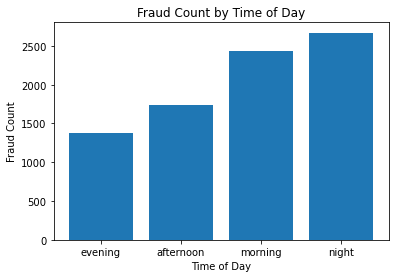

In [99]:
%%local
import matplotlib.pyplot as plt

plt.bar(pandas_df['ToD'], pandas_df['fraud_count'])
plt.xlabel('Time of Day')
plt.ylabel('Fraud Count')
plt.title('Fraud Count by Time of Day')
plt.show()

In [100]:
#Fraud rates by time of day 
avg_fraud_by_ToD = spark.sql("""
    SELECT (time_of_day) as ToD, avg(isFraud) as fraud_avg
    FROM my_table
    GROUP BY time_of_day order by fraud_avg
""")

avg_fraud_by_ToD.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|      ToD|           fraud_avg|
+---------+--------------------+
|  evening|6.759096823076699E-4|
|afternoon|7.877206229610137E-4|
|  morning|0.001449957687219...|
|    night|0.005954279164260052|
+---------+--------------------+

In [101]:
%%spark -o pandas_df2
pandas_df2 = avg_fraud_by_ToD
pandas_df2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|      ToD|           fraud_avg|
+---------+--------------------+
|  evening|6.759096823076699E-4|
|afternoon|7.877206229610137E-4|
|  morning|0.001449957687219...|
|    night|0.005954279164260052|
+---------+--------------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

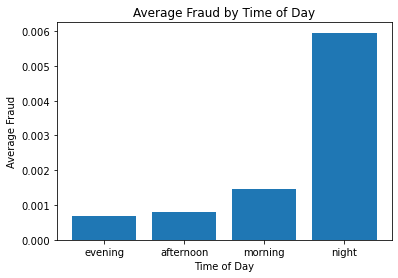

In [102]:
%%local
plt.bar(pandas_df2['ToD'], pandas_df2['fraud_avg'])
plt.xlabel('Time of Day')
plt.ylabel('Average Fraud')
plt.title('Average Fraud by Time of Day')
plt.show()

In [103]:
#group by day and count the number of fraud transactions
fraud_by_day = spark.sql("""
    SELECT day, sum(isFraud) as fraud_count
    FROM my_table
    GROUP BY day order by fraud_count
""")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
%%spark -o pandas_df3
pandas_df3 = fraud_by_day
pandas_df3.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+
|day|fraud_count|
+---+-----------+
| 23|        216|
|  6|        228|
| 20|        236|
| 25|        240|
| 13|        242|
| 14|        246|
| 28|        248|
| 15|        250|
|  5|        252|
| 16|        252|
|  9|        255|
| 19|        256|
| 22|        256|
| 29|        260|
| 11|        262|
|  4|        262|
| 30|        268|
| 18|        268|
|  1|        271|
| 21|        272|
+---+-----------+
only showing top 20 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

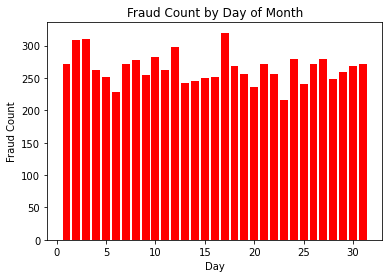

In [105]:
%%local
plt.bar(pandas_df3['day'], pandas_df3['fraud_count'], color = 'red')
plt.xlabel('Day')
plt.ylabel('Fraud Count')
plt.title('Fraud Count by Day of Month')
plt.show()

In [106]:
avg_fraud_by_day = spark.sql("""
    SELECT day, avg(isFraud) as fraud_avg
    FROM my_table
    GROUP BY day order by fraud_avg
""")



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
%%spark -o pandas_df4
pandas_df4 = avg_fraud_by_day
pandas_df4.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+
|day|           fraud_avg|
+---+--------------------+
|  1|4.719157865408224...|
|  6|5.170009410324146E-4|
| 13|5.646514210782976E-4|
|  9|6.101660848154786E-4|
|  8|6.182765208379204E-4|
| 14|6.182830831716414E-4|
| 15|6.230032745052108E-4|
| 11|6.270057603162789E-4|
|  7|6.467213368110456E-4|
| 16|6.709372354190961E-4|
|  2|6.787658323777892E-4|
| 10| 7.17657687462622E-4|
| 17|7.515865522376141E-4|
| 12|8.519738346827684E-4|
| 25|0.004148445197310425|
| 23|0.004234297812279464|
| 29|0.004736746219712151|
| 22|0.004790688100005...|
| 24|0.008560335075972973|
|  4|0.009277620396600567|
+---+--------------------+
only showing top 20 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

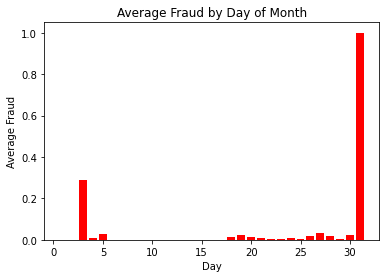

In [108]:
%%local
plt.bar(pandas_df4['day'], pandas_df4['fraud_avg'], color = 'red')
plt.xlabel('Day')
plt.ylabel('Average Fraud')
plt.title('Average Fraud by Day of Month')
plt.show()

In [109]:
#Fraud rates by payment type 
df.createOrReplaceTempView("my_table")
fraud_payment = spark.sql("""
    SELECT (type) as FraudType, avg(isFraud) as fraud_avg
    FROM my_table
    GROUP BY type order by fraud_avg
""")

fraud_payment.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|FraudType|           fraud_avg|
+---------+--------------------+
|    DEBIT|                 0.0|
|  PAYMENT|                 0.0|
|  CASH_IN|                 0.0|
| CASH_OUT|0.001839553072625...|
| TRANSFER|0.007687991758442811|
+---------+--------------------+

In [110]:
%%spark -o pandas_df5
pandas_df5 = fraud_payment
pandas_df5.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|FraudType|           fraud_avg|
+---------+--------------------+
|    DEBIT|                 0.0|
|  PAYMENT|                 0.0|
|  CASH_IN|                 0.0|
| CASH_OUT|0.001839553072625...|
| TRANSFER|0.007687991758442811|
+---------+--------------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

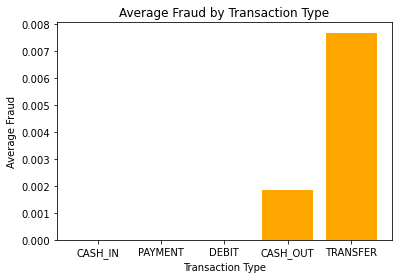

In [111]:
%%local
plt.bar(pandas_df5['FraudType'], pandas_df5['fraud_avg'], color = 'orange')
plt.xlabel('Transaction Type')
plt.ylabel('Average Fraud')
plt.title('Average Fraud by Transaction Type')
plt.show()

In [112]:
#Fraud rates by payment type 
fraud_psum = spark.sql("""
    SELECT (type) as FraudType, sum(isFraud) as fraud_count
    FROM my_table
    GROUP BY type order by fraud_count
""")

fraud_psum.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+
|FraudType|fraud_count|
+---------+-----------+
|    DEBIT|          0|
|  PAYMENT|          0|
|  CASH_IN|          0|
| TRANSFER|       4097|
| CASH_OUT|       4116|
+---------+-----------+

In [113]:
%%spark -o pandas_df6
pandas_df6 = fraud_psum
pandas_df6.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+
|FraudType|fraud_count|
+---------+-----------+
|    DEBIT|          0|
|  PAYMENT|          0|
|  CASH_IN|          0|
| TRANSFER|       4097|
| CASH_OUT|       4116|
+---------+-----------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

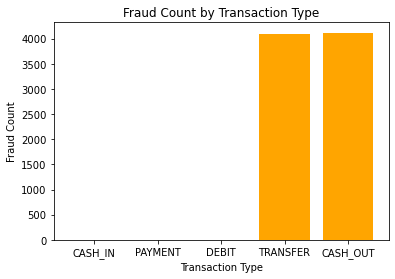

In [114]:
%%local
plt.bar(pandas_df6['FraudType'], pandas_df6['fraud_count'], color = 'orange')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Count')
plt.title('Fraud Count by Transaction Type')
plt.show()

In [122]:
fraud_amount = spark.sql("""
    SELECT mean(amount) as Amount, isFraud
    FROM my_table
    GROUP BY isFraud
""")

fraud_amount.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+
|           Amount|isFraud|
+-----------------+-------+
|1467967.299140387|      1|
| 178197.041727408|      0|
+-----------------+-------+

In [116]:
%%spark -o pandas_df7
pandas_df7 = fraud_amount

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

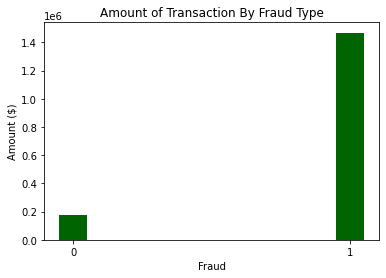

In [117]:
%%local
plt.bar(pandas_df7['isFraud'], pandas_df7['Amount'], color = 'darkgreen', width = 0.1)
plt.xlabel('Fraud')
plt.ylabel('Amount ($)')
plt.title('Amount of Transaction By Fraud Type')
plt.xticks([0, 1])
plt.show()

In [118]:
f = df.filter(df.isFraud == 1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [119]:
%%spark -o fraud_df
fraud_df = f

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

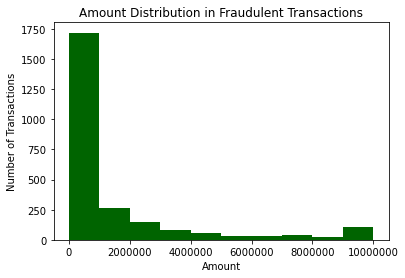

In [120]:
%%local
import matplotlib.pyplot as plt
plt.hist(fraud_df.amount, color='darkgreen')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.title('Amount Distribution in Fraudulent Transactions')
plt.ticklabel_format(style='plain', axis='both')

plt.show()

In [121]:
from pyspark.sql.functions import mean
df.select(mean("Amount")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|       avg(Amount)|
+------------------+
|179861.90354913133|
+------------------+

In [41]:
fraud_old_balance = spark.sql("""
    SELECT mean(oldbalanceOrg) as Old_Balance, isFraud
    FROM my_table
    GROUP BY isFraud
""")

fraud_old_balance.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------+
|       Old_Balance|isFraud|
+------------------+-------+
|1649667.6057116766|      1|
| 832828.7117272614|      0|
+------------------+-------+

In [42]:
cust_fraud = spark.sql("""
    SELECT Type_Orig, sum(isFraud) as fraud_count
    FROM my_table
    GROUP BY Type_Orig
""") 

cust_fraud.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----------+
|    Type_Orig|fraud_count|
+-------------+-----------+
|Customer_Orig|       8213|
+-------------+-----------+

In [43]:
rec_fraud = spark.sql("""
    SELECT Type_Dest, sum(isFraud) as fraud_count
    FROM my_table
    GROUP BY Type_Dest ORDER BY fraud_count
""")

rec_fraud.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----------+
|    Type_Dest|fraud_count|
+-------------+-----------+
|Merchant_Dest|          0|
|Customer_Dest|       8213|
+-------------+-----------+

In [44]:
%%spark -o pandas_df8
pandas_df8 = rec_fraud

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

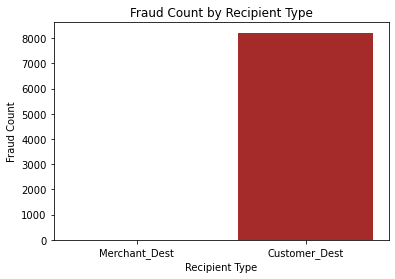

In [45]:
%%local
import matplotlib.pyplot as plt

plt.bar(pandas_df8['Type_Dest'], pandas_df8['fraud_count'], color = "brown")
plt.xlabel('Recipient Type')
plt.ylabel('Fraud Count')
plt.title('Fraud Count by Recipient Type')
plt.show()

In [46]:
fraud_new_balance = spark.sql("""
    SELECT mean(newbalanceOrig) as New_balance, isFraud
    FROM my_table
    GROUP BY isFraud
""")

fraud_new_balance.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------+
|       New_balance|isFraud|
+------------------+-------+
|192392.63183611346|      1|
| 855970.2281088107|      0|
+------------------+-------+

In [47]:
avg_fraud_by_hour = spark.sql("""
    SELECT hour_of_day, avg(isFraud) as fraud_avg
    FROM my_table
    GROUP BY hour_of_day order by fraud_avg
""")
avg_fraud_by_hour.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+
|hour_of_day|           fraud_avg|
+-----------+--------------------+
|         18|5.279293130435587E-4|
|         17|5.908607790749153E-4|
|         19|6.140198797965788E-4|
|         11|7.012564695563673E-4|
|         10|7.264704299628692E-4|
|         12|7.385682022908422E-4|
|         15|7.812287709573109E-4|
|         16|8.023803191791627E-4|
|         13|8.029059280841937E-4|
|         14|8.183620280019007E-4|
|          9|8.808420380100957E-4|
|          8|0.001202745504694...|
|         20|0.001400288935699...|
|         21|0.001804117087712986|
|         22|0.002286612344874944|
|         23|0.004190705016273904|
|          0|0.013204972151525211|
|          7|0.013672673230540592|
|          6| 0.03649310191366266|
|          1| 0.04125083166999335|
+-----------+--------------------+
only showing top 20 rows

In [48]:
%%spark -o pandas_df9
pandas_df9 = avg_fraud_by_hour

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

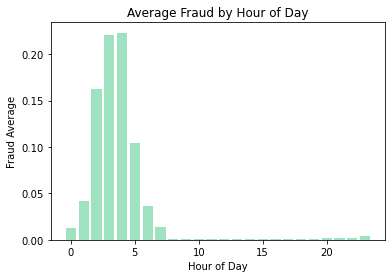

In [49]:
%%local

plt.bar(pandas_df9['hour_of_day'], pandas_df9['fraud_avg'], color = "#9FE2BF")
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Average')
plt.title('Average Fraud by Hour of Day')
plt.show()

Preparing the data for random forest

In [50]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- Type_Dest: string (nullable = false)
 |-- Type_Orig: string (nullable = false)
 |-- hour_of_day: integer (nullable = true)
 |-- day: long (nullable = true)
 |-- time_of_day: string (nullable = false)

In [51]:
unique_vals = df.select('type').distinct().collect()
for val in unique_vals:
    print(val[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

CASH_OUT
CASH_IN
PAYMENT
DEBIT
TRANSFER

Creating dummy columns for categorical variables

In [52]:
from pyspark.sql.functions import col, when, regexp_extract, trim
from pyspark.sql.types import DoubleType, IntegerType

# Convert categorical columns to numerical values using one-hot encoding
df = df.select('*', *[when(col('type') == val, 1).otherwise(0).alias(val) for val in ['CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT', 'PAYMENT']])
df = df.select('*', *[when(col('Type_Orig') == val, 1).otherwise(0).alias(val) for val in ['Merchant_Orig', 'Customer_Orig']])
df = df.select('*', *[when(col('Type_Dest') == val, 1).otherwise(0).alias(val) for val in ['Merchant_Dest', 'Customer_Dest']])
df = df.select('*', *[when(col('time_of_day') == val, 1).otherwise(0).alias(val) for val in ['morning', 'afternoon', 'evening', 'night']])
df = df.drop('type', 'Type_Orig', 'Type_Dest', 'time_of_day')

# Extract numeric value from nameOrig and nameDest columns
df = df.withColumn('nameOrig', regexp_extract(trim(col('nameOrig')), '\d+', 0).cast(IntegerType()))
df = df.withColumn('nameDest', regexp_extract(trim(col('nameDest')), '\d+', 0).cast(IntegerType()))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- step: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: integer (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: integer (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day: long (nullable = true)
 |-- CASH_OUT: integer (nullable = false)
 |-- CASH_IN: integer (nullable = false)
 |-- TRANSFER: integer (nullable = false)
 |-- DEBIT: integer (nullable = false)
 |-- PAYMENT: integer (nullable = false)
 |-- Merchant_Orig: integer (nullable = false)
 |-- Customer_Orig: integer (nullable = false)
 |-- Merchant_Dest: integer (nullable = false)
 |-- Customer_Dest: integer (nullable = false)
 |-- morning: integer (nullable = false)
 |-- afternoon: integer (nullable = false)
 |-- evening: 

In [54]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------+----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-----------+---+--------+-------+--------+-----+-------+-------------+-------------+-------------+-------------+-------+---------+-------+-----+
|step|   amount|  nameOrig|oldbalanceOrg|newbalanceOrig|  nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|hour_of_day|day|CASH_OUT|CASH_IN|TRANSFER|DEBIT|PAYMENT|Merchant_Orig|Customer_Orig|Merchant_Dest|Customer_Dest|morning|afternoon|evening|night|
+----+---------+----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-----------+---+--------+-------+--------+-----+-------+-------------+-------------+-------------+-------------+-------+---------+-------+-----+
|  22|   216.19|1444210311|          0.0|           0.0|1981278780|     498988.87|     499205.05|      0|             0|         21|  1|       0|      0|       0|    1|      0|            0|            1| 

In [55]:
#remove the step column
df = df.drop("step")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Splitting data into train and test

In [56]:
#training = first 16 days, testing = last 11 days 
train = df.filter(df.day <= 16)
test = df.filter(df.day > 16)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#Exploding the Training Data

In [57]:
from pyspark.sql.functions import col, explode, array, lit

major_df = train.filter(col("isFraud") == 0)
minor_df = train.filter(col("isFraud") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ratio: 1301

In [58]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# combine both oversampled minority rows and previous majority rows 
train = major_df.unionAll(oversampled_df)
train.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-----------+---+--------+-------+--------+-----+-------+-------------+-------------+-------------+-------------+-------+---------+-------+-----+
|   amount|  nameOrig|oldbalanceOrg|newbalanceOrig|  nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|hour_of_day|day|CASH_OUT|CASH_IN|TRANSFER|DEBIT|PAYMENT|Merchant_Orig|Customer_Orig|Merchant_Dest|Customer_Dest|morning|afternoon|evening|night|
+---------+----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-----------+---+--------+-------+--------+-----+-------+-------------+-------------+-------------+-------------+-------+---------+-------+-----+
|   216.19|1444210311|          0.0|           0.0|1981278780|     498988.87|     499205.05|      0|             0|         21|  1|       0|      0|       0|    1|      0|            0|            1|            0|       

In [60]:
#checking new ratio 
major_df1 = train.filter(col("isFraud") == 0)
minor_df1 = train.filter(col("isFraud") == 1)
ratio = int(major_df1.count()/minor_df1.count())
print("ratio: {}".format(ratio))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ratio: 1

In [61]:
#checking fraud occurrence different method 
from pyspark.sql.functions import avg as pyspark_avg

train_fraud_avg = train.select(pyspark_avg('isFraud')).collect()[0][0]
print(train_fraud_avg)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.49984641831582854

In [62]:
#counting rows in training and testing df 
num_train = train.count()
num_test = test.count()
print(num_train)
print(num_test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

11111351
800969

In [63]:
#Creating pie charts of fraudulent transactions before and after oversampling 
train_fc = train.groupBy('isFraud').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
%%spark -o pandas_df8
pandas_df8 = train_fc
pandas_df8.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|5557382|
|      1|5553969|
+-------+-------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

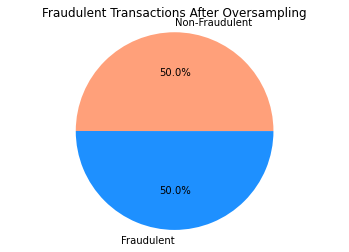

In [65]:
%%local

plt.pie(pandas_df8['count'],  labels = ["Non-Fraudulent", "Fraudulent"], autopct='%1.1f%%',
       colors = ["#FFA07A", "#1E90FF"])

plt.title('Fraudulent Transactions After Oversampling')
plt.axis('equal')
plt.show()


In [66]:
df_fc = df.groupBy('isFraud').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
%%spark -o pandas_df9
pandas_df9 = df_fc
pandas_df9.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

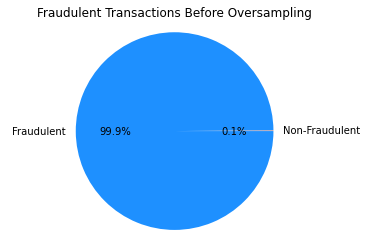

In [68]:
%%local
plt.pie(pandas_df9['count'],  labels = ["Non-Fraudulent", "Fraudulent"], autopct='%1.1f%%',
       colors = ["#FFA07A", "#1E90FF"])

plt.title('Fraudulent Transactions Before Oversampling')
plt.axis('equal')
plt.show()

#Building a random forest model: 

In [69]:
train.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'hour_of_day', 'day', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT', 'PAYMENT', 'Merchant_Orig', 'Customer_Orig', 'Merchant_Dest', 'Customer_Dest', 'morning', 'afternoon', 'evening', 'night']

Random Forest Classifier

In [70]:
# random forest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

# Define the input features

input_cols = ['amount',
'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'hour_of_day',
 'day',
 'CASH_OUT',
 'CASH_IN',
 'TRANSFER',
 'DEBIT',
 'PAYMENT',
 'Merchant_Orig',
 'Customer_Orig',
 'Merchant_Dest',
 'Customer_Dest',
 'morning',
 'afternoon',
 'evening',
 'night']

# Create a vector assembler to combine the input features into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Apply the vector assembler to the training and testing data
train_data = assembler.transform(train).select('features', 'isFraud')
test_data = assembler.transform(test).select('features', 'isFraud')

# Create a random forest classifier
rf = RandomForestClassifier(labelCol='isFraud', featuresCol='features', numTrees=100, maxDepth=10)

# Train the random forest model on the training data
model = rf.fit(train_data)

# Use the trained model to make predictions on the testing data
predictions = model.transform(test_data)

# Evaluate the accuracy of the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='isFraud', metricName='areaUnderROC')
accuracy = evaluator.evaluate(predictions)
print('Model accuracy:', accuracy)









FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model accuracy: 0.9986752151271466

In [71]:
# Get feature importance from the trained model
importances = model.featureImportances

# Create a list of tuples containing feature names and their importances
feature_importances = [(col, imp) for col, imp in zip(input_cols, importances)]

# Sort the list of feature importances in descending order by importance score
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print feature importance scores in descending order
for i in range(len(sorted_importances)):
    print(sorted_importances[i][0], ':', sorted_importances[i][1])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

oldbalanceOrg : 0.24089989311776158
newbalanceOrig : 0.15598985564112494
amount : 0.13285955357280493
TRANSFER : 0.07295905097111487
oldbalanceDest : 0.05539257092576984
newbalanceDest : 0.05492754344852346
PAYMENT : 0.050463682383019313
hour_of_day : 0.05038407268936841
Merchant_Dest : 0.04639942691236968
CASH_IN : 0.04631031620964999
CASH_OUT : 0.039958007253188654
Customer_Dest : 0.031462433693321266
night : 0.00881758319597734
day : 0.007481839655305205
evening : 0.001967160042923653
afternoon : 0.0010845550096934891
nameOrig : 0.0009672669471757947
nameDest : 0.000952185805299145
DEBIT : 0.0003328517300616235
morning : 0.00022840400039785428
isFlaggedFraud : 0.00016174679514880305
Merchant_Orig : 0.0
Customer_Orig : 0.0

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate precision and recall using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)
evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='weightedRecall')
recall = evaluator.evaluate(predictions)

# Print precision and recall
print('Precision:', precision)
print('Recall:', recall)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Precision: 0.9958505179460942
Recall: 0.9778468330235003

In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a multiclass classification evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='accuracy')

# Compute the confusion matrix
confusion_matrix = predictions.groupBy('isFraud', 'prediction').count().orderBy('isFraud', 'prediction')

# Print the confusion matrix
confusion_matrix.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|779366|
|      0|       1.0| 17659|
|      1|       0.0|    85|
|      1|       1.0|  3859|
+-------+----------+------+